# Image Enhancement using Retinex-Net algorithm with Attention Mechanisms
Done by Gary Yee Siew Wah (S2190954)

In [1]:
from skimage.metrics import structural_similarity as ssim
from skimage.metrics import peak_signal_noise_ratio
from skimage import io
import math
import torch
import torchvision.transforms as transforms
import torchvision.models as models
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
import time
import os
import random
from PIL import Image
from glob import glob
from tqdm import tqdm
import pickle

In [2]:
import tensorflow.compat.v1 as tf
tf.disable_v2_behavior()


Instructions for updating:
non-resource variables are not supported in the long term


In [3]:
def load_images(file):
    im = Image.open(file)
    newsize = (128, 128)
    im = im.resize(newsize)
    return np.array(im, dtype="float32") / 255.0

## Training data

In [4]:
train_low_data_names = glob('./data/our485/low/*.png')
train_high_data_names = glob('./data/our485/high/*.png')
train_low_data_names.sort()
train_high_data_names.sort()
assert len(train_low_data_names) == len(train_high_data_names)


low_data_train = []
high_data_train = []

for idx in tqdm(range(len(train_low_data_names))):
    low_im = load_images(train_low_data_names[idx])
    low_data_train.append(low_im)
    high_im = load_images(train_high_data_names[idx])
    high_data_train.append(high_im)

100%|██████████| 485/485 [00:08<00:00, 60.59it/s]


In [5]:
print('Number of training data points: %d' % len(low_data_train))

Number of training data points: 485


## Validation data

In [6]:
low_data_eval = []

eval_low_data_name = glob('./data/eval15/low/*.png')

for idx in tqdm(range(len(eval_low_data_name))):
    eval_low_im = load_images(eval_low_data_name[idx])
    low_data_eval.append(eval_low_im)

100%|██████████| 15/15 [00:00<00:00, 128.28it/s]


In [7]:
high_data_eval = []

eval_high_data_name = glob('./data/eval15/high/*.png')

for idx in tqdm(range(len(eval_high_data_name))):
    eval_high_im = load_images(eval_high_data_name[idx])
    high_data_eval.append(eval_high_im)

100%|██████████| 15/15 [00:00<00:00, 118.29it/s]


In [8]:
print('Number of testing data points: %d' % len(eval_low_data_name))

Number of testing data points: 15


## Plot low light and high light image

In [9]:
low_img = low_data_train[200]
print("Shape of the image", low_img.shape)

Shape of the image (128, 128, 3)


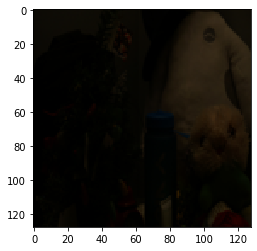

In [10]:
plt.imshow(low_img[ : , : , :])

In [11]:
high_img = high_data_train[200]
print("Shape of the image", high_img.shape)

Shape of the image (128, 128, 3)


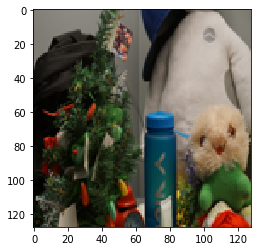

In [12]:
plt.imshow(high_img[ : , : , :])

In [13]:
def concat(layers):
    return tf.concat(layers, axis=3)

In [14]:
def eca_layer(x, gamma=2, b=1):
    """
    Efficient Channel Attention (ECA) layer.
    Args:
        x: Input tensor.
        gamma: Scaling factor for the attention.
        b: Bias term for the attention.
    Returns:
        Output tensor after applying ECA layer.
    """
    t = int(x.shape[-1])
    k = int(max(1, t // gamma))
    avg_pool = tf.reduce_mean(x, axis=[1, 2], keepdims=True)
    conv = tf.compat.v1.layers.conv2d(avg_pool, filters=k, kernel_size=1, activation=tf.nn.relu, padding='same')
    conv = tf.compat.v1.layers.conv2d(conv, filters=t, kernel_size=1, padding='same')
    b = tf.convert_to_tensor(b, dtype=tf.float32)  # Ensure b is a tensor
    att = tf.sigmoid(conv + b)
    return x * att


def deep_connected_attention(input_tensor, channels, idx):
    """
    Deep Connected Attention layer.
    Args:
        input_tensor: Input tensor.
        channels: Number of channels in the input tensor.
        idx: Layer index for variable scope naming.
    Returns:
        Output tensor after applying deep connected attention.
    """
    with tf.compat.v1.variable_scope(f'dca_{idx}', reuse=tf.compat.v1.AUTO_REUSE):
        attention = tf.reduce_mean(input_tensor, axis=[1, 2], keepdims=True)
        attention = tf.compat.v1.layers.conv2d(attention, channels, kernel_size=1, activation=tf.nn.relu, padding='same')
        attention = tf.compat.v1.layers.conv2d(attention, channels, kernel_size=1, padding='same')
        attention = tf.sigmoid(attention)
        output_tensor = input_tensor * attention
    return output_tensor


def DecomNet(input_im, layer_num, channel=64, kernel_size=3):
    """
    Decomposition Network.
    Args:
        input_im: Input image tensor.
        layer_num: Number of layers in the network.
        channel: Number of channels in each layer.
        kernel_size: Kernel size for convolutional layers.
    Returns:
        R: Reflectance component.
        L: Illumination component.
    """
    input_max = tf.reduce_max(input_tensor=input_im, axis=3, keepdims=True)
    input_im = tf.concat([input_max, input_im], axis=-1)
    with tf.compat.v1.variable_scope('DecomNet', reuse=tf.compat.v1.AUTO_REUSE):
        conv = tf.compat.v1.layers.conv2d(input_im, channel, kernel_size * 3, padding='same', activation=None, name="shallow_feature_extraction")
        for idx in range(layer_num):
            if idx % 2 == 0:  
                conv = eca_layer(conv)  # Apply ECA layer
            conv = tf.compat.v1.layers.conv2d(conv, channel, kernel_size, padding='same', activation=tf.nn.relu, name=f'activated_layer_{idx}')
            if idx % 2 == 0:  
                conv = deep_connected_attention(conv, channel, idx)  # Apply DCA layer
        conv = tf.compat.v1.layers.conv2d(conv, 4, kernel_size, padding='same', activation=None, name='recon_layer')

    R = tf.sigmoid(conv[:, :, :, 0:3])
    L = tf.sigmoid(conv[:, :, :, 3:4])

    return R, L



In [15]:
def RelightNet(input_L, input_R, channel=64, kernel_size=3):
    input_im = tf.concat([input_R, input_L], axis=-1)
    with tf.compat.v1.variable_scope('RelightNet', reuse=tf.compat.v1.AUTO_REUSE):
        conv0 = tf.compat.v1.layers.conv2d(input_im, channel, kernel_size, padding='same', activation=None)

        conv1 = tf.compat.v1.layers.conv2d(conv0, channel, kernel_size, strides=2, padding='same', activation=tf.nn.relu)
        conv1 = eca_layer(conv1)  # First ECA layer after conv1
        conv1 = deep_connected_attention(conv1, channel, 0)  # First DCA layer after first ECA layer

        conv2 = tf.compat.v1.layers.conv2d(conv1, channel, kernel_size, strides=2, padding='same', activation=tf.nn.relu)
        conv2 = eca_layer(conv2)  # Second ECA layer after conv2
        conv2 = deep_connected_attention(conv2, channel, 1)  # Second DCA layer after second ECA layer

        conv3 = tf.compat.v1.layers.conv2d(conv2, channel, kernel_size, strides=2, padding='same', activation=tf.nn.relu)
        conv3 = eca_layer(conv3)  # Third ECA layer after conv3
        conv3 = deep_connected_attention(conv3, channel, 2)  # Third DCA layer after third ECA layer

        up1 = tf.image.resize(conv3, (tf.shape(input=conv2)[1], tf.shape(input=conv2)[2]), method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
        deconv1 = tf.compat.v1.layers.conv2d(up1, channel, kernel_size, padding='same', activation=tf.nn.relu) + conv2

        up2 = tf.image.resize(deconv1, (tf.shape(input=conv1)[1], tf.shape(input=conv1)[2]), method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
        deconv2 = tf.compat.v1.layers.conv2d(up2, channel, kernel_size, padding='same', activation=tf.nn.relu) + conv1

        up3 = tf.image.resize(deconv2, (tf.shape(input=conv0)[1], tf.shape(input=conv0)[2]), method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
        deconv3 = tf.compat.v1.layers.conv2d(up3, channel, kernel_size, padding='same', activation=tf.nn.relu) + conv0

        deconv1_resize = tf.image.resize(deconv1, (tf.shape(input=deconv3)[1], tf.shape(input=deconv3)[2]), method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
        deconv2_resize = tf.image.resize(deconv2, (tf.shape(input=deconv3)[1], tf.shape(input=deconv3)[2]), method=tf.image.ResizeMethod.NEAREST_NEIGHBOR)
        feature_gather = tf.concat([deconv1_resize, deconv2_resize, deconv3], axis=-1)
        
        feature_fusion = tf.compat.v1.layers.conv2d(feature_gather, channel, 1, padding='same', activation=None)
        feature_fusion = eca_layer(feature_fusion)  # Fourth ECA layer before final output

        output = tf.compat.v1.layers.conv2d(feature_fusion, 1, 3, padding='same', activation=None)
    return output




In [16]:
def data_augmentation(image, mode):
    if mode == 0:
        # original
        return image
    elif mode == 1:
        # flip up and down
        return np.flipud(image)
    elif mode == 2:
        # rotate counterwise 90 degree
        return np.rot90(image)
    elif mode == 3:
        # rotate 90 degree and flip up and down
        image = np.rot90(image)
        return np.flipud(image)
    elif mode == 4:
        # rotate 180 degree
        return np.rot90(image, k=2)
    elif mode == 5:
        # rotate 180 degree and flip
        image = np.rot90(image, k=2)
        return np.flipud(image)
    elif mode == 6:
        # rotate 270 degree
        return np.rot90(image, k=3)
    elif mode == 7:
        # rotate 270 degree and flip
        image = np.rot90(image, k=3)
        return np.flipud(image)

# Decomposition

In [17]:
class decomposition_enhance:

  def __init__(self, low_data_train, high_data_train, low_data_eval, batch_size, patch_size, epoch, learning_rate, train_phase, ckpt_dir):

    self.DecomNet_layer_num = 5
    self.sess = tf.compat.v1.Session()

    self.low_data_train = low_data_train
    self.high_data_train = high_data_train
    self.low_data_eval = low_data_eval
    self.batch_size = batch_size
    self.patch_size = patch_size
    self.epoch = epoch
    self.learning_rate = learning_rate
    self.train_phase = train_phase

    self.hp_low_data_train = tf.compat.v1.placeholder(tf.float32, [None, None, None, 3], name='hp_low_data_train')
    self.hp_high_data_train = tf.compat.v1.placeholder(tf.float32, [None, None, None, 3], name='hp_high_data_train')
    self.lr_ph = tf.compat.v1.placeholder(tf.float32, name='lr_ph')

    self.ckpt_dir = ckpt_dir

    [R_low, I_low] = DecomNet(self.hp_low_data_train, layer_num=self.DecomNet_layer_num)
    [R_high, I_high] = DecomNet(self.hp_high_data_train, layer_num=self.DecomNet_layer_num)

    I_low_3 = concat([I_low, I_low, I_low])
    I_high_3 = concat([I_high, I_high, I_high])

    self.output_R_low = R_low
    self.output_I_low = I_low_3

    # loss
    self.low_recon_loss = tf.reduce_mean(input_tensor=tf.abs(R_low * I_low_3 -  self.hp_low_data_train))
    self.high_recon_loss = tf.reduce_mean(input_tensor=tf.abs(R_high * I_high_3 - self.hp_high_data_train))
    self.mutal_low_recon_loss = tf.reduce_mean(input_tensor=tf.abs(R_high * I_low_3 - self.hp_low_data_train))
    self.mutal_high_recon_loss = tf.reduce_mean(input_tensor=tf.abs(R_low * I_high_3 - self.hp_high_data_train))
    self.equal_R_loss = tf.reduce_mean(input_tensor=tf.abs(R_low - R_high))

    self.low_Ismooth_loss = self.smooth(I_low, R_low)
    self.high_Ismooth_loss = self.smooth(I_high, R_high)

    self.loss_Decom = self.low_recon_loss + self.high_recon_loss + 0.001 * self.mutal_low_recon_loss + 0.001 * self.mutal_high_recon_loss + 0.1 * self.low_Ismooth_loss + 0.1 * self.high_Ismooth_loss + 0.01 * self.equal_R_loss

    self.lr_ph = tf.compat.v1.placeholder(tf.float32, name='learning_rate')
    optimizer = tf.compat.v1.train.AdamOptimizer(self.lr_ph, name='AdamOptimizer')

    self.var_Decom = [var for var in tf.compat.v1.trainable_variables() if 'DecomNet' in var.name]

    self.train_op_Decom = optimizer.minimize(self.loss_Decom, var_list = self.var_Decom)

    self.sess.run(tf.compat.v1.global_variables_initializer())

    self.saver_Decom = tf.compat.v1.train.Saver(var_list = self.var_Decom)

    print("[*] Initialize model successfully...")

  def gradient(self, input_tensor, direction):
    self.smooth_kernel_x = tf.reshape(tf.constant([[0, 0], [-1, 1]], tf.float32), [2, 2, 1, 1])
    self.smooth_kernel_y = tf.transpose(a=self.smooth_kernel_x, perm=[1, 0, 2, 3])

    if direction == "x":
        kernel = self.smooth_kernel_x
    elif direction == "y":
        kernel = self.smooth_kernel_y
    return tf.abs(tf.nn.conv2d(input=input_tensor, filters=kernel, strides=[1, 1, 1, 1], padding='SAME'))

  def ave_gradient(self, input_tensor, direction):
    return tf.compat.v1.layers.average_pooling2d(self.gradient(input_tensor, direction), pool_size=3, strides=1, padding='SAME')

  def smooth(self, input_I, input_R):
    input_R = tf.image.rgb_to_grayscale(input_R)
    return tf.reduce_mean(input_tensor=self.gradient(input_I, "x") * tf.exp(-10 * self.ave_gradient(input_R, "x")) + self.gradient(input_I, "y") * tf.exp(-10 * self.ave_gradient(input_R, "y")))

  def evaluate_test(self):

    print("Evaluating for test data")
    Reflectance = []
    Illuminance = []

    for idx in range(len(self.low_data_eval)):
      input_low_eval = np.expand_dims(self.low_data_eval[idx], axis=0)

      if self.train_phase == "Decom":
        result_1, result_2 = self.sess.run([self.output_R_low, self.output_I_low], feed_dict={self.hp_low_data_train: input_low_eval})

      Reflectance.append(result_1)
      Illuminance.append(result_2)

    return Reflectance, Illuminance

  def evaluate_train(self):

    print("Evaluating for train data")
    Reflectance = []
    Illuminance = []

    for idx in tqdm(range(len(self.low_data_train))):
      input_low_train = np.expand_dims(self.low_data_train[idx], axis=0)

      if self.train_phase == "Decom":
        result_1, result_2 = self.sess.run([self.output_R_low, self.output_I_low], feed_dict={self.hp_low_data_train: input_low_train})

      Reflectance.append(result_1)
      Illuminance.append(result_2)

    return Reflectance, Illuminance

  def train(self):

    numBatch = 30

    # load pretrained model

    train_op = self.train_op_Decom
    train_loss = self.loss_Decom
    saver = self.saver_Decom

    iter_num = 0
    start_epoch = 0
    start_step = 0
    lr1 = self.learning_rate

    start_time = time.time()
    image_id = 0

    for epoch in range(start_epoch, self.epoch):

      for batch_id in range(start_step, numBatch):

        # generate data for a batch
        batch_input_low = np.zeros((self.batch_size, self.patch_size, self.patch_size, 3), dtype="float32")
        batch_input_high = np.zeros((self.batch_size, self.patch_size, self.patch_size, 3), dtype="float32")
        for patch_id in range(self.batch_size):

          h, w, _ = self.low_data_train[image_id].shape
          x = random.randint(0, h - self.patch_size)
          y = random.randint(0, w - self.patch_size)

          rand_mode = random.randint(0, 7)
          batch_input_low[patch_id, :, :, :] = data_augmentation(self.low_data_train[image_id][x : x+self.patch_size, y : y+self.patch_size, :], rand_mode)
          batch_input_high[patch_id, :, :, :] = data_augmentation(self.high_data_train[image_id][x : x+self.patch_size, y : y+self.patch_size, :], rand_mode)

          image_id = (image_id + 1) % len(self.low_data_train)
          if image_id == 0:
            tmp = list(zip(self.low_data_train, self.high_data_train))
            random.shuffle(list(tmp))
            low_data_train, high_data_train  = zip(*tmp)

        # train
        _, loss = self.sess.run([train_op, train_loss], feed_dict={self.hp_low_data_train: batch_input_low, \
                                                                    self.hp_high_data_train: batch_input_high, \
                                                                    self.lr_ph: lr1[epoch]})

        print("%s Epoch: [%2d] [%4d/%4d] time: %4.4f, loss: %.6f" \
                      % (train_phase, epoch + 1, batch_id + 1, numBatch, time.time() - start_time, loss))
        iter_num += 1
            

  def save(self, saver, ckpt_dir, model_name):
      if not os.path.exists(ckpt_dir):
          print("Directory does not exist:", ckpt_dir)
          os.makedirs(ckpt_dir)
          print("Directory created successfully.")
      else:
          print("Directory already exists:", ckpt_dir)

      print("[*] Saving model %s" % model_name)
      saver.save(self.sess, os.path.join(ckpt_dir, model_name))


  def load(self, saver, ckpt_dir):
      ckpt = tf.train.get_checkpoint_state(ckpt_dir)
      if ckpt and ckpt.model_checkpoint_path:
         # Extract the directory of the checkpoint file
         ckpt_path = ckpt.model_checkpoint_path
        # Restore the model
         saver.restore(self.sess, ckpt_path)
         print("[*] Model restored from:", ckpt_path)
         return True
      else:
         print("[!] No checkpoint found in:", ckpt_dir)
         return False
    

In [18]:
epoch = 40
learning_rate = 0.001 * np.ones([epoch])
learning_rate[20:] = learning_rate[0] / 10.0
batch_size = 16
patch_size = 48
train_phase = "Decom"
ckpt_dir = "./data/ckpt"

In [19]:
model = decomposition_enhance(low_data_train, high_data_train, low_data_eval, batch_size, patch_size, epoch, learning_rate, train_phase, ckpt_dir)


Instructions for updating:
Use `tf.keras.layers.Conv2D` instead.
Instructions for updating:
Please use `layer.__call__` method instead.
Instructions for updating:
Use keras.layers.AveragePooling2D instead.
[*] Initialize model successfully...


In [20]:
model.train()

Decom Epoch: [ 1] [   1/  30] time: 1.5434, loss: 0.437119
Decom Epoch: [ 1] [   2/  30] time: 2.4167, loss: 0.509714
Decom Epoch: [ 1] [   3/  30] time: 3.3057, loss: 0.458385
Decom Epoch: [ 1] [   4/  30] time: 4.1673, loss: 0.419554
Decom Epoch: [ 1] [   5/  30] time: 5.0376, loss: 0.346710
Decom Epoch: [ 1] [   6/  30] time: 5.9218, loss: 0.413385
Decom Epoch: [ 1] [   7/  30] time: 6.8196, loss: 0.324096
Decom Epoch: [ 1] [   8/  30] time: 7.7290, loss: 0.364466
Decom Epoch: [ 1] [   9/  30] time: 8.6132, loss: 0.360322
Decom Epoch: [ 1] [  10/  30] time: 9.5011, loss: 0.351098
Decom Epoch: [ 1] [  11/  30] time: 10.4342, loss: 0.355199
Decom Epoch: [ 1] [  12/  30] time: 11.3698, loss: 0.387390
Decom Epoch: [ 1] [  13/  30] time: 12.5287, loss: 0.369536
Decom Epoch: [ 1] [  14/  30] time: 13.5326, loss: 0.372283
Decom Epoch: [ 1] [  15/  30] time: 14.5287, loss: 0.313791
Decom Epoch: [ 1] [  16/  30] time: 15.4895, loss: 0.261305
Decom Epoch: [ 1] [  17/  30] time: 16.4911, loss:

Decom Epoch: [ 5] [  18/  30] time: 148.5372, loss: 0.115618
Decom Epoch: [ 5] [  19/  30] time: 149.6007, loss: 0.114537
Decom Epoch: [ 5] [  20/  30] time: 150.7105, loss: 0.079895
Decom Epoch: [ 5] [  21/  30] time: 151.7818, loss: 0.112033
Decom Epoch: [ 5] [  22/  30] time: 152.7870, loss: 0.102097
Decom Epoch: [ 5] [  23/  30] time: 153.7896, loss: 0.094238
Decom Epoch: [ 5] [  24/  30] time: 154.8691, loss: 0.131722
Decom Epoch: [ 5] [  25/  30] time: 155.8908, loss: 0.087623
Decom Epoch: [ 5] [  26/  30] time: 156.8997, loss: 0.104870
Decom Epoch: [ 5] [  27/  30] time: 158.0130, loss: 0.077843
Decom Epoch: [ 5] [  28/  30] time: 159.1231, loss: 0.069797
Decom Epoch: [ 5] [  29/  30] time: 160.1649, loss: 0.083517
Decom Epoch: [ 5] [  30/  30] time: 161.2454, loss: 0.093067
Decom Epoch: [ 6] [   1/  30] time: 162.3096, loss: 0.075043
Decom Epoch: [ 6] [   2/  30] time: 163.3600, loss: 0.089114
Decom Epoch: [ 6] [   3/  30] time: 164.4080, loss: 0.084878
Decom Epoch: [ 6] [   4/

Decom Epoch: [10] [   3/  30] time: 292.4308, loss: 0.062639
Decom Epoch: [10] [   4/  30] time: 293.4546, loss: 0.064098
Decom Epoch: [10] [   5/  30] time: 294.4341, loss: 0.062295
Decom Epoch: [10] [   6/  30] time: 295.3912, loss: 0.054476
Decom Epoch: [10] [   7/  30] time: 296.3649, loss: 0.068430
Decom Epoch: [10] [   8/  30] time: 297.3282, loss: 0.048861
Decom Epoch: [10] [   9/  30] time: 298.3022, loss: 0.073973
Decom Epoch: [10] [  10/  30] time: 299.3355, loss: 0.063992
Decom Epoch: [10] [  11/  30] time: 300.2673, loss: 0.042717
Decom Epoch: [10] [  12/  30] time: 301.2310, loss: 0.079619
Decom Epoch: [10] [  13/  30] time: 302.2628, loss: 0.093357
Decom Epoch: [10] [  14/  30] time: 303.2584, loss: 0.089964
Decom Epoch: [10] [  15/  30] time: 304.2484, loss: 0.092340
Decom Epoch: [10] [  16/  30] time: 305.2252, loss: 0.083069
Decom Epoch: [10] [  17/  30] time: 306.1985, loss: 0.065093
Decom Epoch: [10] [  18/  30] time: 307.1668, loss: 0.075982
Decom Epoch: [10] [  19/

Decom Epoch: [14] [  18/  30] time: 425.4561, loss: 0.079083
Decom Epoch: [14] [  19/  30] time: 426.5181, loss: 0.062146
Decom Epoch: [14] [  20/  30] time: 427.5303, loss: 0.051269
Decom Epoch: [14] [  21/  30] time: 428.5336, loss: 0.055167
Decom Epoch: [14] [  22/  30] time: 429.5874, loss: 0.063246
Decom Epoch: [14] [  23/  30] time: 430.6025, loss: 0.057644
Decom Epoch: [14] [  24/  30] time: 431.5851, loss: 0.053009
Decom Epoch: [14] [  25/  30] time: 432.5978, loss: 0.061828
Decom Epoch: [14] [  26/  30] time: 433.5941, loss: 0.061844
Decom Epoch: [14] [  27/  30] time: 434.7601, loss: 0.093281
Decom Epoch: [14] [  28/  30] time: 435.8822, loss: 0.066662
Decom Epoch: [14] [  29/  30] time: 436.9585, loss: 0.066777
Decom Epoch: [14] [  30/  30] time: 437.9447, loss: 0.050592
Decom Epoch: [15] [   1/  30] time: 438.9706, loss: 0.067282
Decom Epoch: [15] [   2/  30] time: 440.0179, loss: 0.063870
Decom Epoch: [15] [   3/  30] time: 441.0785, loss: 0.065067
Decom Epoch: [15] [   4/

Decom Epoch: [19] [   3/  30] time: 570.3272, loss: 0.043145
Decom Epoch: [19] [   4/  30] time: 571.7431, loss: 0.049372
Decom Epoch: [19] [   5/  30] time: 572.9004, loss: 0.045421
Decom Epoch: [19] [   6/  30] time: 574.1167, loss: 0.045548
Decom Epoch: [19] [   7/  30] time: 575.3046, loss: 0.042398
Decom Epoch: [19] [   8/  30] time: 576.4041, loss: 0.050875
Decom Epoch: [19] [   9/  30] time: 577.4584, loss: 0.065562
Decom Epoch: [19] [  10/  30] time: 578.4586, loss: 0.045039
Decom Epoch: [19] [  11/  30] time: 579.4919, loss: 0.040451
Decom Epoch: [19] [  12/  30] time: 580.5377, loss: 0.055503
Decom Epoch: [19] [  13/  30] time: 581.7203, loss: 0.048265
Decom Epoch: [19] [  14/  30] time: 582.8670, loss: 0.033370
Decom Epoch: [19] [  15/  30] time: 583.9004, loss: 0.061285
Decom Epoch: [19] [  16/  30] time: 584.9783, loss: 0.063015
Decom Epoch: [19] [  17/  30] time: 586.1161, loss: 0.066470
Decom Epoch: [19] [  18/  30] time: 587.1477, loss: 0.062049
Decom Epoch: [19] [  19/

Decom Epoch: [23] [  18/  30] time: 716.9920, loss: 0.052314
Decom Epoch: [23] [  19/  30] time: 718.2586, loss: 0.053606
Decom Epoch: [23] [  20/  30] time: 719.8115, loss: 0.053030
Decom Epoch: [23] [  21/  30] time: 720.9464, loss: 0.054789
Decom Epoch: [23] [  22/  30] time: 722.2238, loss: 0.044331
Decom Epoch: [23] [  23/  30] time: 723.3748, loss: 0.035210
Decom Epoch: [23] [  24/  30] time: 724.4530, loss: 0.038539
Decom Epoch: [23] [  25/  30] time: 725.5422, loss: 0.032693
Decom Epoch: [23] [  26/  30] time: 726.5722, loss: 0.033425
Decom Epoch: [23] [  27/  30] time: 727.6061, loss: 0.039719
Decom Epoch: [23] [  28/  30] time: 728.5802, loss: 0.041738
Decom Epoch: [23] [  29/  30] time: 729.6086, loss: 0.043077
Decom Epoch: [23] [  30/  30] time: 730.6324, loss: 0.060877
Decom Epoch: [24] [   1/  30] time: 731.6466, loss: 0.036760
Decom Epoch: [24] [   2/  30] time: 732.6899, loss: 0.035854
Decom Epoch: [24] [   3/  30] time: 733.9315, loss: 0.038622
Decom Epoch: [24] [   4/

Decom Epoch: [28] [   3/  30] time: 868.5259, loss: 0.031924
Decom Epoch: [28] [   4/  30] time: 869.5802, loss: 0.040166
Decom Epoch: [28] [   5/  30] time: 870.5810, loss: 0.031934
Decom Epoch: [28] [   6/  30] time: 871.6026, loss: 0.040899
Decom Epoch: [28] [   7/  30] time: 872.6442, loss: 0.032880
Decom Epoch: [28] [   8/  30] time: 873.6747, loss: 0.027214
Decom Epoch: [28] [   9/  30] time: 874.6760, loss: 0.036037
Decom Epoch: [28] [  10/  30] time: 875.6823, loss: 0.032926
Decom Epoch: [28] [  11/  30] time: 876.7121, loss: 0.028330
Decom Epoch: [28] [  12/  30] time: 877.7142, loss: 0.042614
Decom Epoch: [28] [  13/  30] time: 878.7799, loss: 0.029541
Decom Epoch: [28] [  14/  30] time: 879.8507, loss: 0.032966
Decom Epoch: [28] [  15/  30] time: 880.8737, loss: 0.035332
Decom Epoch: [28] [  16/  30] time: 881.9945, loss: 0.035315
Decom Epoch: [28] [  17/  30] time: 883.1272, loss: 0.028703
Decom Epoch: [28] [  18/  30] time: 884.3868, loss: 0.042819
Decom Epoch: [28] [  19/

Decom Epoch: [32] [  18/  30] time: 1023.0080, loss: 0.024782
Decom Epoch: [32] [  19/  30] time: 1024.5138, loss: 0.046364
Decom Epoch: [32] [  20/  30] time: 1026.0111, loss: 0.048580
Decom Epoch: [32] [  21/  30] time: 1027.4874, loss: 0.050352
Decom Epoch: [32] [  22/  30] time: 1028.8359, loss: 0.051132
Decom Epoch: [32] [  23/  30] time: 1030.1606, loss: 0.053941
Decom Epoch: [32] [  24/  30] time: 1031.4686, loss: 0.042981
Decom Epoch: [32] [  25/  30] time: 1032.7722, loss: 0.036828
Decom Epoch: [32] [  26/  30] time: 1034.1284, loss: 0.034300
Decom Epoch: [32] [  27/  30] time: 1035.5089, loss: 0.033043
Decom Epoch: [32] [  28/  30] time: 1036.9483, loss: 0.032860
Decom Epoch: [32] [  29/  30] time: 1038.1947, loss: 0.032860
Decom Epoch: [32] [  30/  30] time: 1039.3973, loss: 0.038581
Decom Epoch: [33] [   1/  30] time: 1040.7035, loss: 0.035390
Decom Epoch: [33] [   2/  30] time: 1041.9202, loss: 0.043334
Decom Epoch: [33] [   3/  30] time: 1043.0630, loss: 0.050684
Decom Ep

Decom Epoch: [37] [   1/  30] time: 1168.6455, loss: 0.036151
Decom Epoch: [37] [   2/  30] time: 1169.7640, loss: 0.038039
Decom Epoch: [37] [   3/  30] time: 1170.8470, loss: 0.036498
Decom Epoch: [37] [   4/  30] time: 1171.8699, loss: 0.059797
Decom Epoch: [37] [   5/  30] time: 1172.8894, loss: 0.036452
Decom Epoch: [37] [   6/  30] time: 1173.9077, loss: 0.034324
Decom Epoch: [37] [   7/  30] time: 1175.0481, loss: 0.035153
Decom Epoch: [37] [   8/  30] time: 1176.1030, loss: 0.032197
Decom Epoch: [37] [   9/  30] time: 1177.1040, loss: 0.033787
Decom Epoch: [37] [  10/  30] time: 1178.1217, loss: 0.034433
Decom Epoch: [37] [  11/  30] time: 1179.1463, loss: 0.026580
Decom Epoch: [37] [  12/  30] time: 1180.1877, loss: 0.035148
Decom Epoch: [37] [  13/  30] time: 1181.3354, loss: 0.029181
Decom Epoch: [37] [  14/  30] time: 1182.6976, loss: 0.028945
Decom Epoch: [37] [  15/  30] time: 1183.8952, loss: 0.030094
Decom Epoch: [37] [  16/  30] time: 1185.0564, loss: 0.028061
Decom Ep

In [21]:
Reflectance, Illuminance = model.evaluate_train()

  0%|          | 1/485 [00:00<01:09,  6.92it/s]

Evaluating for train data


100%|██████████| 485/485 [00:27<00:00, 17.91it/s]


In [22]:
Reflectance_test, Illuminance_test = model.evaluate_test()

Evaluating for test data


## Plotting Reflectance and Illuminantion 

In [23]:
R_img = Reflectance[0]
I_img = Illuminance[0]

R_img = R_img[0,:,:,:]
I_img = I_img[0,:,:,:]

#print(img.shape)
print(R_img.shape)
print(I_img.shape)

(128, 128, 3)
(128, 128, 3)


Plotting Reflectance of an image

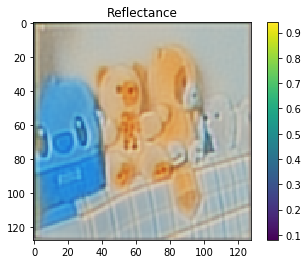

In [24]:
plt.imshow(R_img)
plt.title('Reflectance')
plt.colorbar()
plt.show()


Plotting Illuminance of an image

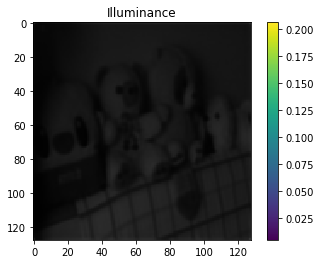

In [25]:
# Display Illuminance image
plt.imshow(I_img)
plt.title('Illuminance')
plt.colorbar()
plt.show()

# Adjustment

In [26]:
Reflectance_1 = list()
for i in tqdm(range(len(Reflectance))):
  R = Reflectance[i]
  R1 = R[0,:,:,:]
  Reflectance_1.append(R1)


100%|██████████| 485/485 [00:00<00:00, 557020.11it/s]


In [27]:
Illuminance_1 = list()
for i in tqdm(range(len(Illuminance))):
  I = Illuminance[i]
  I1 = I[0,:,:,:]
  Illuminance_1.append(I1)

100%|██████████| 485/485 [00:00<00:00, 970070.31it/s]


In [28]:
Reflectance_111 = np.array(Reflectance_1, dtype='float32')
Reflectance_111.shape

(485, 128, 128, 3)

In [29]:
Illuminance_111 = np.array(Illuminance_1, dtype='float32')
Illuminance_111.shape

(485, 128, 128, 3)

In [30]:
Reflectance_test_1 = list()
for i in tqdm(range(len(Reflectance_test))):
  R = Reflectance_test[i]
  R1 = R[0,:,:,:]
  Reflectance_test_1.append(R1)


100%|██████████| 15/15 [00:00<00:00, 30916.25it/s]


In [31]:
Illuminance_test_1 = list()
for i in tqdm(range(len(Illuminance_test))):
  I = Illuminance_test[i]
  I1 = I[0,:,:,:]
  Illuminance_test_1.append(I1)

100%|██████████| 15/15 [00:00<?, ?it/s]


In [32]:
Reflectance_test_111 = np.array(Reflectance_test_1, dtype='float32')
Reflectance_test_111.shape

(15, 128, 128, 3)

In [33]:
Illuminance_test_111 = np.array(Illuminance_test_1, dtype='float32')
Illuminance_test_111.shape

(15, 128, 128, 3)

# Relight model

In [34]:
class enhancement:

  def __init__(self, high_data_train,  Reflectance, Illuminance, Reflectance_test, Illuminance_test, batch_size, patch_size, epoch, learning_rate, train_phase, ckpt_dir_2):

    self.sess = tf.compat.v1.Session()

    self.high_data_train = high_data_train

    self.R_low = np.array(Reflectance)
    self.I_low = np.array(Illuminance)

    self.R_low_test = np.array(Reflectance_test)
    self.I_low_test = np.array(Illuminance_test)

    self.batch_size = batch_size
    self.patch_size = patch_size
    self.epoch = epoch
    self.learning_rate = learning_rate
    self.train_phase = train_phase

    self.ph_high_data_train = tf.compat.v1.placeholder(tf.float32, [None, None, None, 3], name='ph_high_data_train')
    self.R_low_ph = tf.compat.v1.placeholder(tf.float32, [None, None, None, 3], name='R_low_ph')
    self.I_low_ph = tf.compat.v1.placeholder(tf.float32, [None, None, None, 3], name='I_low_ph')

    self.lr_ph = tf.compat.v1.placeholder(tf.float32, name='lr_ph')

    self.ckpt_dir_2 = ckpt_dir_2

    I_delta = RelightNet(self.I_low_ph, self.R_low_ph)

    I_delta_3 = concat([I_delta, I_delta, I_delta])

    self.output_I_delta = I_delta_3

    self.output_S = self.R_low_ph * I_delta_3

    self.relight_loss = tf.reduce_mean(input_tensor=tf.abs(self.R_low_ph * I_delta_3 - self.ph_high_data_train))

    self.Ismooth_loss_delta = self.smooth(I_delta, self.R_low_ph)

    self.loss_Relight = self.relight_loss + 3 * self.Ismooth_loss_delta

    self.lr_ph = tf.compat.v1.placeholder(tf.float32, name='learning_rate')
    optimizer = tf.compat.v1.train.AdamOptimizer(learning_rate=self.lr_ph) ###

    with tf.compat.v1.variable_scope('RelightNet', reuse=tf.compat.v1.AUTO_REUSE):
        self.var_Relight = [var for var in tf.compat.v1.trainable_variables() if 'RelightNet' in var.name]

    with tf.compat.v1.variable_scope('RelightNet', reuse=tf.compat.v1.AUTO_REUSE):
        self.train_op_Relight = optimizer.minimize(self.loss_Relight, var_list=self.var_Relight)

    self.sess.run(tf.compat.v1.global_variables_initializer())

    self.saver_Relight = tf.compat.v1.train.Saver(var_list = self.var_Relight)

    print("[*] Initialize model successfully...")

  def gradient(self, input_tensor, direction):
    self.smooth_kernel_x = tf.reshape(tf.constant([[0, 0], [-1, 1]], tf.float32), [2, 2, 1, 1])
    self.smooth_kernel_y = tf.transpose(a=self.smooth_kernel_x, perm=[1, 0, 2, 3])

    if direction == "x":
        kernel = self.smooth_kernel_x
    elif direction == "y":
        kernel = self.smooth_kernel_y
    return tf.abs(tf.nn.conv2d(input=input_tensor, filters=kernel, strides=[1, 1, 1, 1], padding='SAME'))

  def ave_gradient(self, input_tensor, direction):
    return tf.compat.v1.layers.average_pooling2d(self.gradient(input_tensor, direction), pool_size=3, strides=1, padding='SAME')

  def smooth(self, input_I, input_R):
    input_R = tf.image.rgb_to_grayscale(input_R)
    return tf.reduce_mean(input_tensor=self.gradient(input_I, "x") * tf.exp(-10 * self.ave_gradient(input_R, "x")) + self.gradient(input_I, "y") * tf.exp(-10 * self.ave_gradient(input_R, "y")))

  def evaluate_test(self):

    print("Evaluating for test data")
    R_low_hat = []
    I_low_hat = []

    for idx in range(len(self.R_low_test)):
      input_R_low = np.expand_dims(self.R_low_test[idx], axis=0)
      input_I_low = np.expand_dims(self.I_low_test[idx], axis=0)

      if train_phase == "Relight":
        result_1, result_2 = self.sess.run([self.output_S, self.output_I_delta], feed_dict={self.R_low_ph: input_R_low, self.I_low_ph: input_I_low,})

      R_low_hat.append(result_1)
      I_low_hat.append(result_2)
        

    return R_low_hat, I_low_hat

  def evaluate_train(self):

    print("Evaluating for train data")
    R_low_hat = []
    I_low_hat = []

    for idx in tqdm(range(len(self.R_low))):
    #for idx in tqdm(range(start_id, end_id)):
      input_R_low = np.expand_dims(self.R_low[idx], axis=0)
      input_I_low = np.expand_dims(self.I_low[idx], axis=0)

      if train_phase == "Relight":
        result_1, result_2 = self.sess.run([self.output_S, self.output_I_delta], feed_dict={self.R_low_ph: input_R_low, self.I_low_ph: input_I_low,})

      R_low_hat.append(result_1)
      I_low_hat.append(result_2)

    return R_low_hat, I_low_hat

  def train(self):
     numBatch = 30
     train_op = self.train_op_Relight
     train_loss = self.loss_Relight
     saver = self.saver_Relight
     iter_num = 0
     start_epoch = 0
     start_step = 0
     lr1 = self.learning_rate
     start_time = time.time()
     image_id = 0
     self.train_losses = []
     self.validation_losses = []
     self.train_psnr = []
     self.validation_psnr = []
     self.train_ssim = []
     self.validation_ssim = []
     self.outputs_train = []
     for epoch in range(start_epoch, self.epoch):
         epoch_train_loss = 0
         for batch_id in range(start_step, numBatch):
             # generate data for a batch
             batch_R_low = np.zeros((self.batch_size, 128, 128, 3), dtype="float32")
             batch_I_low = np.zeros((self.batch_size, 128, 128, 3), dtype="float32")
             batch_input_high = np.zeros((self.batch_size, 128, 128, 3), dtype="float32")
             for patch_id in range(self.batch_size):
                 batch_R_low[patch_id, :, :, :] = self.R_low[image_id, :, :, :]
                 batch_I_low[patch_id, :, :, :] = self.I_low[image_id, :, :, :]
                 batch_input_high[patch_id, :, :, :] = self.high_data_train[image_id][:,:,:]
                 image_id = (image_id + 1) % len(self.R_low)
                 if image_id == 0:
                     tmp = list(zip(self.R_low, self.I_low))
                     random.shuffle(tmp)
                     self.R_low, self.I_low = zip(*tmp)
                     self.R_low = np.array(self.R_low)
                     self.I_low = np.array(self.I_low)
                # train
             _, loss, output = self.sess.run([train_op, train_loss, self.output_S], feed_dict={self.R_low_ph: batch_R_low, self.I_low_ph: batch_I_low, self.lr_ph: lr1[epoch], self.ph_high_data_train: batch_input_high})
             epoch_train_loss += loss
             self.outputs_train.append(output)
             print("%s Epoch: [%2d] [%4d/%4d] time: %4.4f, loss: %.6f" % (self.train_phase, epoch + 1, batch_id + 1, numBatch, time.time() - start_time, loss))
             iter_num += 1
         epoch_train_loss /= numBatch
         self.train_losses.append(epoch_train_loss)
         print("Epoch: [%2d] training loss: %.6f" % (epoch + 1, epoch_train_loss))   
         # Evaluate and store validation loss
         val_loss = self.evaluate_validation_loss(self.R_low_test, self.I_low_test, self.high_data_train)
         self.validation_losses.append(val_loss[0])  # Store validation loss
         self.validation_psnr.append(val_loss[1])   # Store validation PSNR
         print("Epoch: [%2d] validation loss: %.6f" % (epoch + 1, val_loss[0]))
            # Evaluate and store PSNR
         train_psnr_value = self.evaluate_psnr(self.R_low, self.I_low, self.high_data_train)
         val_psnr_value = self.evaluate_psnr(self.R_low_test, self.I_low_test, self.high_data_train)
         self.train_psnr.append(train_psnr_value)
         self.validation_psnr.append(val_psnr_value)
         print("Epoch: [%2d] Train PSNR: %.6f, Validation PSNR: %.6f" % (epoch + 1, train_psnr_value, val_psnr_value))
         train_ssim_value = self.evaluate_ssim(self.R_low, self.I_low, self.high_data_train)
         val_ssim_value = self.evaluate_ssim(self.R_low_test, self.I_low_test, self.high_data_train)
         self.train_ssim.append(train_ssim_value)
         self.validation_ssim.append(val_ssim_value)
         print("Epoch: [%2d] Train SSIM: %.6f, Validation SSIM: %.6f" % (epoch + 1, train_ssim_value, val_ssim_value))
         saver.save(self.sess, self.ckpt_dir_2 + "model.ckpt")

  def evaluate_validation_loss(self, R_low_test, I_low_test, high_data):
        num_samples = len(R_low_test)
        total_loss = 0
        total_psnr = 0
        for idx in range(num_samples):
            input_R_low = np.expand_dims(R_low_test[idx], axis=0)
            input_I_low = np.expand_dims(I_low_test[idx], axis=0)
            high_res = np.expand_dims(high_data[idx], axis=0)
            output = self.sess.run(self.output_S, feed_dict={self.R_low_ph: input_R_low, self.I_low_ph: input_I_low})
            loss = np.mean(np.abs(high_res - output))
            psnr = peak_signal_noise_ratio(high_res, output, data_range=1)
            total_loss += loss
            total_psnr += psnr
        average_loss = total_loss / num_samples
        average_psnr = total_psnr / num_samples
        return average_loss, average_psnr
   
    
  def save_2(self, saver, ckpt_dir, model_name):
    if not os.path.exists(ckpt_dir):
      os.makedirs(ckpt_dir)
    print("[*] Saving model %s" % model_name)
    saver.save(self.sess, \
                os.path.join(ckpt_dir, model_name))

  def load_2(self, saver, ckpt_dir):
    ckpt = tf.train.get_checkpoint_state(ckpt_dir)
    full_path = ckpt_dir + '/RetinexNet-Relight'

    saver.restore(self.sess, full_path)
    return True 

  def psnr(self, img1, img2):
      mse = np.mean((img1 - img2) ** 2)
      if mse == 0:
          return float('inf')
      return 20 * np.log10(255.0 / np.sqrt(mse))


  def evaluate_psnr(self, data_R_low, data_I_low, data_high):
      psnr_values = []
      for i in range(len(data_R_low)):
          input_R_low = np.expand_dims(data_R_low[i], axis=0)
          input_I_low = np.expand_dims(data_I_low[i], axis=0)
          high = data_high[i]

          result_S, result_I_delta = self.sess.run([self.output_S, self.output_I_delta],
                                                      feed_dict={self.R_low_ph: input_R_low, self.I_low_ph: input_I_low})
          result_S = np.squeeze(result_S, axis=0)
          psnr_value = self.psnr(result_S, high)
          psnr_values.append(psnr_value)
      return np.mean(psnr_values)   


  def compute_ssim(self, img1, img2):
      return ssim(img1, img2, multichannel=True)

  def evaluate_ssim(self, data_R_low, data_I_low, data_high):
      ssim_values = []
      for i in range(len(data_R_low)):
          input_R_low = np.expand_dims(data_R_low[i], axis=0)
          input_I_low = np.expand_dims(data_I_low[i], axis=0)
          high = data_high[i]

          result_S, result_I_delta = self.sess.run([self.output_S, self.output_I_delta],
                                                     feed_dict={self.R_low_ph: input_R_low, self.I_low_ph: input_I_low})
          result_S = np.squeeze(result_S, axis=0)
          ssim_value = self.compute_ssim(result_S, high)
          ssim_values.append(ssim_value)
      return np.mean(ssim_values)

In [35]:
train_phase = "Relight"
ckpt_dir_2 = "./data/ckpt_2"

In [36]:
model2 = enhancement(high_data_train, Reflectance_111, Illuminance_111, Reflectance_test_111, Illuminance_test_111, batch_size, patch_size, epoch, learning_rate, train_phase, ckpt_dir_2)

[*] Initialize model successfully...


In [37]:
model2.train()

Relight Epoch: [ 1] [   1/  30] time: 3.2041, loss: 0.525522
Relight Epoch: [ 1] [   2/  30] time: 6.1814, loss: 0.317298
Relight Epoch: [ 1] [   3/  30] time: 9.6159, loss: 0.254252
Relight Epoch: [ 1] [   4/  30] time: 13.0688, loss: 0.262416
Relight Epoch: [ 1] [   5/  30] time: 16.5332, loss: 0.201876
Relight Epoch: [ 1] [   6/  30] time: 19.5118, loss: 0.194124
Relight Epoch: [ 1] [   7/  30] time: 22.3060, loss: 0.195829
Relight Epoch: [ 1] [   8/  30] time: 25.3743, loss: 0.208956
Relight Epoch: [ 1] [   9/  30] time: 29.3475, loss: 0.196737
Relight Epoch: [ 1] [  10/  30] time: 33.8043, loss: 0.246577
Relight Epoch: [ 1] [  11/  30] time: 37.1470, loss: 0.204902
Relight Epoch: [ 1] [  12/  30] time: 41.0002, loss: 0.208169
Relight Epoch: [ 1] [  13/  30] time: 43.6322, loss: 0.196101
Relight Epoch: [ 1] [  14/  30] time: 46.4336, loss: 0.216693
Relight Epoch: [ 1] [  15/  30] time: 50.1632, loss: 0.181134
Relight Epoch: [ 1] [  16/  30] time: 53.9424, loss: 0.175813
Relight Epo

Epoch: [ 4] Train SSIM: 0.428519, Validation SSIM: 0.404312
Relight Epoch: [ 5] [   1/  30] time: 577.3880, loss: 0.257718
Relight Epoch: [ 5] [   2/  30] time: 580.5232, loss: 0.239798
Relight Epoch: [ 5] [   3/  30] time: 584.5833, loss: 0.279481
Relight Epoch: [ 5] [   4/  30] time: 588.1039, loss: 0.259251
Relight Epoch: [ 5] [   5/  30] time: 591.6267, loss: 0.241905
Relight Epoch: [ 5] [   6/  30] time: 594.9020, loss: 0.199865
Relight Epoch: [ 5] [   7/  30] time: 598.1831, loss: 0.222281
Relight Epoch: [ 5] [   8/  30] time: 601.5656, loss: 0.200163
Relight Epoch: [ 5] [   9/  30] time: 605.2719, loss: 0.190269
Relight Epoch: [ 5] [  10/  30] time: 608.3900, loss: 0.197934
Relight Epoch: [ 5] [  11/  30] time: 611.7818, loss: 0.222956
Relight Epoch: [ 5] [  12/  30] time: 615.9812, loss: 0.227720
Relight Epoch: [ 5] [  13/  30] time: 620.1168, loss: 0.254870
Relight Epoch: [ 5] [  14/  30] time: 623.9171, loss: 0.253968
Relight Epoch: [ 5] [  15/  30] time: 627.9193, loss: 0.28

Epoch: [ 8] validation loss: 0.226332
Epoch: [ 8] Train PSNR: 60.842988, Validation PSNR: 59.778207
Epoch: [ 8] Train SSIM: 0.427423, Validation SSIM: 0.402987
Relight Epoch: [ 9] [   1/  30] time: 1189.5469, loss: 0.173819
Relight Epoch: [ 9] [   2/  30] time: 1192.6936, loss: 0.190819
Relight Epoch: [ 9] [   3/  30] time: 1196.1022, loss: 0.241450
Relight Epoch: [ 9] [   4/  30] time: 1200.0380, loss: 0.252429
Relight Epoch: [ 9] [   5/  30] time: 1203.4721, loss: 0.269302
Relight Epoch: [ 9] [   6/  30] time: 1206.4790, loss: 0.233523
Relight Epoch: [ 9] [   7/  30] time: 1209.4190, loss: 0.187512
Relight Epoch: [ 9] [   8/  30] time: 1212.3238, loss: 0.215112
Relight Epoch: [ 9] [   9/  30] time: 1215.7686, loss: 0.197204
Relight Epoch: [ 9] [  10/  30] time: 1219.2044, loss: 0.181352
Relight Epoch: [ 9] [  11/  30] time: 1222.3698, loss: 0.185206
Relight Epoch: [ 9] [  12/  30] time: 1226.1991, loss: 0.225366
Relight Epoch: [ 9] [  13/  30] time: 1229.1017, loss: 0.220294
Relight 

Relight Epoch: [12] [  28/  30] time: 1691.0789, loss: 0.174480
Relight Epoch: [12] [  29/  30] time: 1694.2617, loss: 0.181095
Relight Epoch: [12] [  30/  30] time: 1697.5685, loss: 0.151812
Epoch: [12] training loss: 0.205731
Epoch: [12] validation loss: 0.221575
Epoch: [12] Train PSNR: 60.929825, Validation PSNR: 59.928587
Epoch: [12] Train SSIM: 0.421928, Validation SSIM: 0.400948
Relight Epoch: [13] [   1/  30] time: 1747.2233, loss: 0.159536
Relight Epoch: [13] [   2/  30] time: 1750.1303, loss: 0.179830
Relight Epoch: [13] [   3/  30] time: 1752.9442, loss: 0.178067
Relight Epoch: [13] [   4/  30] time: 1755.9250, loss: 0.254839
Relight Epoch: [13] [   5/  30] time: 1758.7066, loss: 0.248282
Relight Epoch: [13] [   6/  30] time: 1761.5902, loss: 0.263116
Relight Epoch: [13] [   7/  30] time: 1764.6473, loss: 0.241357
Relight Epoch: [13] [   8/  30] time: 1767.6365, loss: 0.195699
Relight Epoch: [13] [   9/  30] time: 1770.3213, loss: 0.200402
Relight Epoch: [13] [  10/  30] time

Relight Epoch: [16] [  24/  30] time: 2270.7362, loss: 0.185337
Relight Epoch: [16] [  25/  30] time: 2274.9869, loss: 0.219633
Relight Epoch: [16] [  26/  30] time: 2278.5335, loss: 0.237971
Relight Epoch: [16] [  27/  30] time: 2281.5336, loss: 0.185949
Relight Epoch: [16] [  28/  30] time: 2284.4678, loss: 0.177995
Relight Epoch: [16] [  29/  30] time: 2287.2387, loss: 0.168980
Relight Epoch: [16] [  30/  30] time: 2290.2705, loss: 0.192911
Epoch: [16] training loss: 0.205988
Epoch: [16] validation loss: 0.217086
Epoch: [16] Train PSNR: 60.902988, Validation PSNR: 60.052800
Epoch: [16] Train SSIM: 0.415322, Validation SSIM: 0.394331
Relight Epoch: [17] [   1/  30] time: 2339.5673, loss: 0.168481
Relight Epoch: [17] [   2/  30] time: 2342.5467, loss: 0.160675
Relight Epoch: [17] [   3/  30] time: 2345.3912, loss: 0.177937
Relight Epoch: [17] [   4/  30] time: 2348.1675, loss: 0.166145
Relight Epoch: [17] [   5/  30] time: 2350.9601, loss: 0.244381
Relight Epoch: [17] [   6/  30] time

Relight Epoch: [20] [  20/  30] time: 2854.5518, loss: 0.266368
Relight Epoch: [20] [  21/  30] time: 2857.5405, loss: 0.206791
Relight Epoch: [20] [  22/  30] time: 2860.4205, loss: 0.179711
Relight Epoch: [20] [  23/  30] time: 2863.3538, loss: 0.209154
Relight Epoch: [20] [  24/  30] time: 2866.4730, loss: 0.190555
Relight Epoch: [20] [  25/  30] time: 2869.7648, loss: 0.193684
Relight Epoch: [20] [  26/  30] time: 2872.7723, loss: 0.197509
Relight Epoch: [20] [  27/  30] time: 2875.5144, loss: 0.246512
Relight Epoch: [20] [  28/  30] time: 2878.2878, loss: 0.186998
Relight Epoch: [20] [  29/  30] time: 2881.1607, loss: 0.174079
Relight Epoch: [20] [  30/  30] time: 2884.1084, loss: 0.176739
Epoch: [20] training loss: 0.204639
Epoch: [20] validation loss: 0.216331
Epoch: [20] Train PSNR: 60.912446, Validation PSNR: 60.069960
Epoch: [20] Train SSIM: 0.413814, Validation SSIM: 0.392881
Relight Epoch: [21] [   1/  30] time: 2932.3581, loss: 0.190954
Relight Epoch: [21] [   2/  30] time

Relight Epoch: [24] [  16/  30] time: 3404.9182, loss: 0.192008
Relight Epoch: [24] [  17/  30] time: 3407.6839, loss: 0.210839
Relight Epoch: [24] [  18/  30] time: 3410.8697, loss: 0.203629
Relight Epoch: [24] [  19/  30] time: 3414.4185, loss: 0.216835
Relight Epoch: [24] [  20/  30] time: 3417.3471, loss: 0.228636
Relight Epoch: [24] [  21/  30] time: 3420.1312, loss: 0.251073
Relight Epoch: [24] [  22/  30] time: 3423.5379, loss: 0.221868
Relight Epoch: [24] [  23/  30] time: 3426.7198, loss: 0.180051
Relight Epoch: [24] [  24/  30] time: 3429.8704, loss: 0.204098
Relight Epoch: [24] [  25/  30] time: 3433.6925, loss: 0.182282
Relight Epoch: [24] [  26/  30] time: 3436.6748, loss: 0.193733
Relight Epoch: [24] [  27/  30] time: 3439.4616, loss: 0.191168
Relight Epoch: [24] [  28/  30] time: 3443.1922, loss: 0.247605
Relight Epoch: [24] [  29/  30] time: 3446.4622, loss: 0.178640
Relight Epoch: [24] [  30/  30] time: 3449.4290, loss: 0.178944
Epoch: [24] training loss: 0.197100
Epoc

Relight Epoch: [28] [  12/  30] time: 3896.7692, loss: 0.217133
Relight Epoch: [28] [  13/  30] time: 3899.5121, loss: 0.162490
Relight Epoch: [28] [  14/  30] time: 3902.2770, loss: 0.205062
Relight Epoch: [28] [  15/  30] time: 3905.2819, loss: 0.178285
Relight Epoch: [28] [  16/  30] time: 3908.2825, loss: 0.181594
Relight Epoch: [28] [  17/  30] time: 3911.1358, loss: 0.176752
Relight Epoch: [28] [  18/  30] time: 3913.9178, loss: 0.209926
Relight Epoch: [28] [  19/  30] time: 3916.5675, loss: 0.203758
Relight Epoch: [28] [  20/  30] time: 3919.2268, loss: 0.203092
Relight Epoch: [28] [  21/  30] time: 3922.1261, loss: 0.223175
Relight Epoch: [28] [  22/  30] time: 3925.0473, loss: 0.250646
Relight Epoch: [28] [  23/  30] time: 3927.8573, loss: 0.257156
Relight Epoch: [28] [  24/  30] time: 3930.4407, loss: 0.180889
Relight Epoch: [28] [  25/  30] time: 3933.0890, loss: 0.200415
Relight Epoch: [28] [  26/  30] time: 3935.6812, loss: 0.199402
Relight Epoch: [28] [  27/  30] time: 39

Relight Epoch: [32] [   8/  30] time: 4417.1891, loss: 0.187311
Relight Epoch: [32] [   9/  30] time: 4420.1316, loss: 0.180967
Relight Epoch: [32] [  10/  30] time: 4422.8672, loss: 0.244412
Relight Epoch: [32] [  11/  30] time: 4425.4955, loss: 0.215023
Relight Epoch: [32] [  12/  30] time: 4427.9709, loss: 0.220826
Relight Epoch: [32] [  13/  30] time: 4430.4845, loss: 0.214551
Relight Epoch: [32] [  14/  30] time: 4432.9987, loss: 0.179081
Relight Epoch: [32] [  15/  30] time: 4435.7044, loss: 0.190535
Relight Epoch: [32] [  16/  30] time: 4438.3766, loss: 0.202274
Relight Epoch: [32] [  17/  30] time: 4440.9293, loss: 0.173160
Relight Epoch: [32] [  18/  30] time: 4443.4412, loss: 0.173738
Relight Epoch: [32] [  19/  30] time: 4446.2432, loss: 0.201342
Relight Epoch: [32] [  20/  30] time: 4449.1208, loss: 0.216851
Relight Epoch: [32] [  21/  30] time: 4451.9593, loss: 0.184709
Relight Epoch: [32] [  22/  30] time: 4454.7568, loss: 0.226576
Relight Epoch: [32] [  23/  30] time: 44

Relight Epoch: [36] [   4/  30] time: 4963.2050, loss: 0.177986
Relight Epoch: [36] [   5/  30] time: 4966.0306, loss: 0.169604
Relight Epoch: [36] [   6/  30] time: 4968.9413, loss: 0.185231
Relight Epoch: [36] [   7/  30] time: 4971.6050, loss: 0.155037
Relight Epoch: [36] [   8/  30] time: 4974.3507, loss: 0.165602
Relight Epoch: [36] [   9/  30] time: 4977.5124, loss: 0.190143
Relight Epoch: [36] [  10/  30] time: 4980.6261, loss: 0.177065
Relight Epoch: [36] [  11/  30] time: 4983.8408, loss: 0.224826
Relight Epoch: [36] [  12/  30] time: 4987.1408, loss: 0.228180
Relight Epoch: [36] [  13/  30] time: 4990.2510, loss: 0.213148
Relight Epoch: [36] [  14/  30] time: 4993.0409, loss: 0.203220
Relight Epoch: [36] [  15/  30] time: 4996.0415, loss: 0.196214
Relight Epoch: [36] [  16/  30] time: 4999.2208, loss: 0.180928
Relight Epoch: [36] [  17/  30] time: 5002.3438, loss: 0.210433
Relight Epoch: [36] [  18/  30] time: 5005.6758, loss: 0.181377
Relight Epoch: [36] [  19/  30] time: 50

Epoch: [39] Train SSIM: 0.414615, Validation SSIM: 0.393646
Relight Epoch: [40] [   1/  30] time: 5543.0036, loss: 0.187588
Relight Epoch: [40] [   2/  30] time: 5546.0381, loss: 0.199080
Relight Epoch: [40] [   3/  30] time: 5548.8988, loss: 0.236815
Relight Epoch: [40] [   4/  30] time: 5551.5993, loss: 0.179794
Relight Epoch: [40] [   5/  30] time: 5554.4880, loss: 0.173486
Relight Epoch: [40] [   6/  30] time: 5557.4870, loss: 0.170961
Relight Epoch: [40] [   7/  30] time: 5560.4586, loss: 0.192675
Relight Epoch: [40] [   8/  30] time: 5563.3980, loss: 0.161704
Relight Epoch: [40] [   9/  30] time: 5566.7331, loss: 0.154227
Relight Epoch: [40] [  10/  30] time: 5569.8498, loss: 0.188064
Relight Epoch: [40] [  11/  30] time: 5572.7585, loss: 0.168473
Relight Epoch: [40] [  12/  30] time: 5575.7382, loss: 0.222771
Relight Epoch: [40] [  13/  30] time: 5578.9887, loss: 0.217105
Relight Epoch: [40] [  14/  30] time: 5582.0683, loss: 0.205760
Relight Epoch: [40] [  15/  30] time: 5584.9

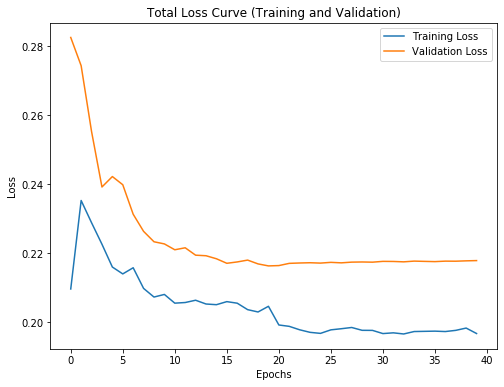

In [38]:
# Plotting the losses for model2
train_losses_2 = model2.train_losses
val_losses_2 = model2.validation_losses

plt.figure(figsize=(8, 6))
plt.plot(train_losses_2, label='Training Loss')
plt.plot(val_losses_2, label='Validation Loss')
plt.title('Total Loss Curve (Training and Validation)')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

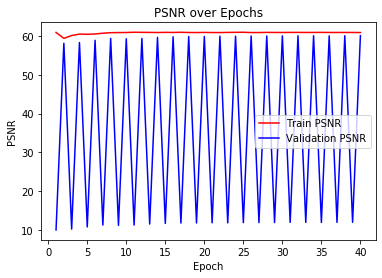

In [39]:
epochs = range(1, model2.epoch + 1)

# Check and adjust lengths if necessary
min_length = min(len(model2.train_psnr), len(model2.validation_psnr))
train_psnr = model2.train_psnr[:min_length]
validation_psnr = model2.validation_psnr[:min_length]
epochs = range(1, min_length + 1)

plt.figure()
plt.plot(epochs, train_psnr, 'r', label='Train PSNR')
plt.plot(epochs, validation_psnr, 'b', label='Validation PSNR')
plt.xlabel('Epoch')
plt.ylabel('PSNR')
plt.title('PSNR over Epochs')
plt.legend()
plt.show()


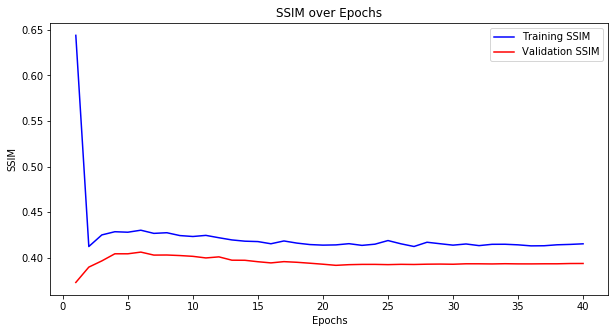

In [40]:
# Plotting SSIM curves
epochs = range(1, model2.epoch + 1)

plt.figure(figsize=(10, 5))
plt.plot(epochs, model2.train_ssim, 'b', label='Training SSIM')
plt.plot(epochs, model2.validation_ssim, 'r', label='Validation SSIM')
plt.title('SSIM over Epochs')
plt.xlabel('Epochs')
plt.ylabel('SSIM')
plt.legend()
plt.show()

In [41]:
Output_S, Output_I_delta = model2.evaluate_train()

  0%|          | 2/485 [00:00<00:26, 18.13it/s]

Evaluating for train data


100%|██████████| 485/485 [00:22<00:00, 21.32it/s]


In [42]:
Output_S_test, Output_I_delta_test = model2.evaluate_test()

Evaluating for test data


## Plotting a sample low light and high light image (validation data)

In [43]:
hl_img = Output_S_test[0]
hl_img2 = Output_I_delta_test[0]

hl_img = hl_img[0,:,:,:]
hl_img2 = hl_img2[0,:,:,:]

low_img = low_data_eval[0]
high_img = high_data_eval[0]

In [44]:
hl_image_final = hl_img*hl_img2

Text(0.5, 1.0, 'Predicted High light image')

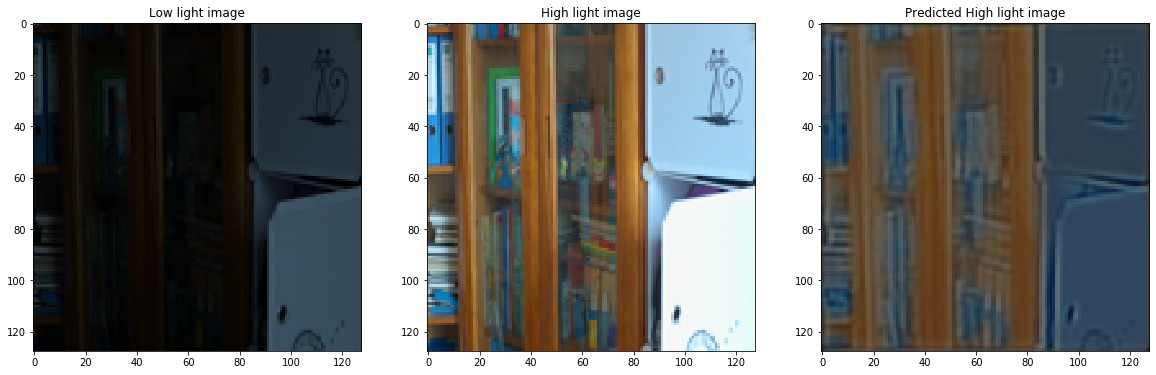

In [45]:
plt.figure(figsize=(20,12))

plt.subplot(1,3,1)
plt.imshow(low_img[ : , : , :])
plt.title('Low light image')

plt.subplot(1,3,2)
plt.imshow(high_img[ : , : , :])
plt.title('High light image')

plt.subplot(1,3,3)
plt.imshow(hl_image_final[ : , : , :])
plt.title('Predicted High light image')

# SSIM

In [46]:
image1 = low_img  
image2 = hl_image_final  

# Compute SSIM
ssim_score = ssim(image1, image2, multichannel=True)

print(f"SSIM: {ssim_score}")
#Higher SSIM better

SSIM: 0.419015336983987


# PSNR

In [47]:
original_image = low_img
reconstructed_image = hl_image_final

mse = np.mean((original_image - reconstructed_image)**2)

max_pixel_value = 255
psnr = 10 * np.log10((max_pixel_value**2)/mse)

print(f"PSNR: {psnr} dB")
#Higher PSNR better

PSNR: 61.575560848564294 dB
